In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
from IPython.display import display
import time 
import tracker
import seaborn as sns
from matplotlib import pyplot as plt
latest_date = tracker.processing_dates[-1]
os.chdir('/mnt/BioAdHoc/Groups/vd-ay/hichip-db-loop-calling/')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [2]:
# setting input and output with jupyter notebook in context 
if 'ipykernel_launcher.py' in sys.argv[0]:
    input_fn = 'results/samplesheets/hicpro/{}.hicpro.samplesheet.with_header.tsv'.format(latest_date) 
    split_fastqs = 'results/samplesheets/fastq/{}.fastq.post-check.split_fastqs.with_header.tsv'.format(latest_date)
    hicpro_fn = 'results/samplesheets/fastq/{}.fastq.post-check.run_hicpro'.format(latest_date)
else:
    input_fn = sys.argv[1]
    split_fastqs = sys.argv[2]
    hicpro_fn = sys.argv[3]

## Helper Functions

In [3]:
def get_log(x, mode='index'):
    
    if mode == 'index':
        logs = glob.glob('results/fastqs/raw/logs/download_srr_fastqs.*-{}'.format(x))
        
    elif mode == 'path':
        info = x.split('/')
        sample_name = info[3]
        srr_id  = info[4].split('.')[0].split('_')[0]
        index = df.loc[(df[0] == sample_name) & (df[3] == srr_id)].iloc[0].name
        logs = glob.glob('results/fastqs/raw/logs/download_srr_fastqs.*-{}'.format(index))
        
    else:
        return('Try again.')
    
    return(logs)

def list_to_str(l, sep=' '):
    l = [str(x) for x in l]
    return(sep.join(l))

In [4]:
def read_hicpro_step2_log(log):
    
    """
    Read the log and extract status information including
    the sample_name, srr_id, status (as indicated by the end message),
    and the download status (as indicate by the "reads written" message).
    """
        
    # initializing the statuses to 0
    hicpro_status = 0

    if os.path.exists(log):
        with open(log, errors='ignore') as fr:
            for line in fr:
                info = line.strip()
                if 'Run ICE Normalization ...' in info:
                    hicpro_status = 1
    return(hicpro_status)

In [5]:
def long_to_short_index_list(serial_list):
    
    if len(serial_list) == 0:
        serial_list_short = []
        
    elif len(serial_list) == 1:
        serial_list_short = [str(serial_list[0])]
        
    else:
        small_num = serial_list[0]
        serial_list_short = []
        for i in range(1, len(serial_list)):

            prev_num = serial_list[i -1]
            next_num = serial_list[i]

            if (prev_num + 1) != next_num:

                if small_num == prev_num:
                    curr_range = '{}'.format(small_num)
                    serial_list_short.append(curr_range)
                    small_num = next_num

                else:
                    curr_range = '{}-{}'.format(small_num, prev_num)
                    serial_list_short.append(curr_range)
                    small_num = next_num

        if small_num == next_num:
            curr_range = '{}'.format(small_num,)
            serial_list_short.append(curr_range)
        else:
            curr_range = '{}-{}'.format(small_num, next_num)
            serial_list_short.append(curr_range)

    return(serial_list_short)

## Check HiCPro Main Logs

In [6]:
# load the samplesheet table
df = pd.read_table(input_fn)
df['sample_index'] = df.index + 1

In [7]:
log_data = []
for i, sr in df.iterrows():
    
    s1_log = glob.glob('results/hicpro/{}/HiCpro_s1_.e*'.format(sr.std_sample_name))
    s2_log = glob.glob('results/hicpro/{}/HiCpro_s2_.e*'.format(sr.std_sample_name))
    
    # check if s1 steps have started
    if len(s1_log) > 0:
        hicpro_start_status = 1
    else:
        hicpro_start_status = 0
    
    # check if s2 steps have ended 
    if len(s2_log) == 1:
        s2_log = s2_log[0]
        hicpro_end_status = read_hicpro_step2_log(s2_log)
    else:
        hicpro_end_status = 0 
        
    log_data.append([sr.std_sample_name, hicpro_start_status, hicpro_end_status])

log_df = pd.DataFrame(log_data)
log_df.columns = ['std_sample_name', 'hicpro_start_status', 'hicpro_ended_status']    

In [8]:
# merge the log information
df = df.merge(log_df, how='left', on=['std_sample_name'], indicator='merge')

In [9]:
df.head()

,std_sample_name,gse_id,organism,bio_rep,antibody_target,restriction_enzyme,sample_name,sample_index,hicpro_start_status,hicpro_ended_status,merge
0,HAVIC.GSE154512.Homo_Sapiens.H3K27ac.b1,GSE154512,Homo_Sapiens,1,H3K27ac,MboI,HAVIC,1,1,1,both
1,HCT116-AuxinNeg.GSE179544.Homo_Sapiens.RNA-Pol...,GSE179544,Homo_Sapiens,1,RNA-Pol-II,DpnII,HCT116-AuxinNeg,2,0,0,both
2,HCT116-AuxinPos.GSE179544.Homo_Sapiens.RNA-Pol...,GSE179544,Homo_Sapiens,1,RNA-Pol-II,DpnII,HCT116-AuxinPos,3,0,0,both
3,IMR90-Proliferating.GSE100856.Homo_Sapiens.CTC...,GSE100856,Homo_Sapiens,1,CTCF,HindIII,IMR90-Proliferating,4,0,0,both
4,IMR90-Senescent.GSE100856.Homo_Sapiens.CTCF.b1,GSE100856,Homo_Sapiens,1,CTCF,HindIII,IMR90-Senescent,5,0,0,both


#### add the split data

In [10]:
split_df = pd.read_table(split_fastqs)
df = df.merge(split_df[['std_sample_name', 'gse_id', 'split_fastqs_end_status']], on=['std_sample_name', 'gse_id'])

In [11]:
df

,std_sample_name,gse_id,organism,bio_rep,antibody_target,restriction_enzyme,sample_name,sample_index,hicpro_start_status,hicpro_ended_status,merge,split_fastqs_end_status
0,HAVIC.GSE154512.Homo_Sapiens.H3K27ac.b1,GSE154512,Homo_Sapiens,1,H3K27ac,MboI,HAVIC,1,1,1,both,1
1,HCT116-AuxinNeg.GSE179544.Homo_Sapiens.RNA-Pol...,GSE179544,Homo_Sapiens,1,RNA-Pol-II,DpnII,HCT116-AuxinNeg,2,0,0,both,0
2,HCT116-AuxinPos.GSE179544.Homo_Sapiens.RNA-Pol...,GSE179544,Homo_Sapiens,1,RNA-Pol-II,DpnII,HCT116-AuxinPos,3,0,0,both,0
3,IMR90-Proliferating.GSE100856.Homo_Sapiens.CTC...,GSE100856,Homo_Sapiens,1,CTCF,HindIII,IMR90-Proliferating,4,0,0,both,0
4,IMR90-Senescent.GSE100856.Homo_Sapiens.CTCF.b1,GSE100856,Homo_Sapiens,1,CTCF,HindIII,IMR90-Senescent,5,0,0,both,1
5,HUVEC-Proliferating.GSE100856.Homo_Sapiens.CTC...,GSE100856,Homo_Sapiens,1,CTCF,HindIII,HUVEC-Proliferating,6,0,0,both,1
6,HUVEC-Senescent.GSE100856.Homo_Sapiens.CTCF.b1,GSE100856,Homo_Sapiens,1,CTCF,HindIII,HUVEC-Senescent,7,0,0,both,1
7,Hela-S3-Control.GSE108869.Homo_Sapiens.CTCF.b1,GSE108869,Homo_Sapiens,1,CTCF,MboI,Hela-S3-Control,8,0,0,both,0
8,Hela-S3-Control.GSE108869.Homo_Sapiens.CTCF.b2,GSE108869,Homo_Sapiens,2,CTCF,MboI,Hela-S3-Control,9,0,0,both,0
9,Hela-S3-OE.GSE108869.Homo_Sapiens.CTCF.b1,GSE108869,Homo_Sapiens,1,CTCF,MboI,Hela-S3-OE,10,0,0,both,0


## Identifying problem samples

In [12]:
problems = (df.split_fastqs_end_status == 0) & (df.hicpro_start_status == 0)
problems_df = df.loc[problems,:]
problems_df

,std_sample_name,gse_id,organism,bio_rep,antibody_target,restriction_enzyme,sample_name,sample_index,hicpro_start_status,hicpro_ended_status,merge,split_fastqs_end_status
1,HCT116-AuxinNeg.GSE179544.Homo_Sapiens.RNA-Pol...,GSE179544,Homo_Sapiens,1,RNA-Pol-II,DpnII,HCT116-AuxinNeg,2,0,0,both,0
2,HCT116-AuxinPos.GSE179544.Homo_Sapiens.RNA-Pol...,GSE179544,Homo_Sapiens,1,RNA-Pol-II,DpnII,HCT116-AuxinPos,3,0,0,both,0
3,IMR90-Proliferating.GSE100856.Homo_Sapiens.CTC...,GSE100856,Homo_Sapiens,1,CTCF,HindIII,IMR90-Proliferating,4,0,0,both,0
7,Hela-S3-Control.GSE108869.Homo_Sapiens.CTCF.b1,GSE108869,Homo_Sapiens,1,CTCF,MboI,Hela-S3-Control,8,0,0,both,0
8,Hela-S3-Control.GSE108869.Homo_Sapiens.CTCF.b2,GSE108869,Homo_Sapiens,2,CTCF,MboI,Hela-S3-Control,9,0,0,both,0
9,Hela-S3-OE.GSE108869.Homo_Sapiens.CTCF.b1,GSE108869,Homo_Sapiens,1,CTCF,MboI,Hela-S3-OE,10,0,0,both,0
17,Nalm6.GSE115492.Homo_Sapiens.H3K27ac.b1,GSE115492,Homo_Sapiens,1,H3K27ac,MboI,Nalm6,18,0,0,both,0
19,GM12878.GSE115524.Homo_Sapiens.CTCF.b2,GSE115524,Homo_Sapiens,2,CTCF,MboI,GM12878,20,0,0,both,0
25,MB157-WT.GSE116869.Homo_Sapiens.SMC1A.b1,GSE116869,Homo_Sapiens,1,SMC1A,MboI,MB157-WT,26,0,0,both,0
26,MB157-GSI.GSE116869.Homo_Sapiens.SMC1A.b1,GSE116869,Homo_Sapiens,1,SMC1A,MboI,MB157-GSI,27,0,0,both,0


## Re-run problematic/ready samples

In [13]:
df

,std_sample_name,gse_id,organism,bio_rep,antibody_target,restriction_enzyme,sample_name,sample_index,hicpro_start_status,hicpro_ended_status,merge,split_fastqs_end_status
0,HAVIC.GSE154512.Homo_Sapiens.H3K27ac.b1,GSE154512,Homo_Sapiens,1,H3K27ac,MboI,HAVIC,1,1,1,both,1
1,HCT116-AuxinNeg.GSE179544.Homo_Sapiens.RNA-Pol...,GSE179544,Homo_Sapiens,1,RNA-Pol-II,DpnII,HCT116-AuxinNeg,2,0,0,both,0
2,HCT116-AuxinPos.GSE179544.Homo_Sapiens.RNA-Pol...,GSE179544,Homo_Sapiens,1,RNA-Pol-II,DpnII,HCT116-AuxinPos,3,0,0,both,0
3,IMR90-Proliferating.GSE100856.Homo_Sapiens.CTC...,GSE100856,Homo_Sapiens,1,CTCF,HindIII,IMR90-Proliferating,4,0,0,both,0
4,IMR90-Senescent.GSE100856.Homo_Sapiens.CTCF.b1,GSE100856,Homo_Sapiens,1,CTCF,HindIII,IMR90-Senescent,5,0,0,both,1
5,HUVEC-Proliferating.GSE100856.Homo_Sapiens.CTC...,GSE100856,Homo_Sapiens,1,CTCF,HindIII,HUVEC-Proliferating,6,0,0,both,1
6,HUVEC-Senescent.GSE100856.Homo_Sapiens.CTCF.b1,GSE100856,Homo_Sapiens,1,CTCF,HindIII,HUVEC-Senescent,7,0,0,both,1
7,Hela-S3-Control.GSE108869.Homo_Sapiens.CTCF.b1,GSE108869,Homo_Sapiens,1,CTCF,MboI,Hela-S3-Control,8,0,0,both,0
8,Hela-S3-Control.GSE108869.Homo_Sapiens.CTCF.b2,GSE108869,Homo_Sapiens,2,CTCF,MboI,Hela-S3-Control,9,0,0,both,0
9,Hela-S3-OE.GSE108869.Homo_Sapiens.CTCF.b1,GSE108869,Homo_Sapiens,1,CTCF,MboI,Hela-S3-OE,10,0,0,both,0


In [14]:
rerun_df = df.loc[(df.split_fastqs_end_status == 1) & (df.hicpro_start_status == 0)]
len(rerun_df.sample_index.tolist())

154

In [15]:
# convert not run serial IDs to ranges/short format
rerun_indexes = sorted(rerun_df.sample_index.tolist())
rerun_indexes_sort = long_to_short_index_list(rerun_indexes)

In [16]:
rerun_indexes_sort

['5-7',
 '21-25',
 '33-87',
 '91-126',
 '128-151',
 '153-159',
 '163-171',
 '175-178',
 '180-190']

In [17]:
# generate a string version of not_run
final_rerun = ','.join(rerun_indexes_sort)
final_rerun = 'qsub -t {} workflow/scripts/hicpro/run_hicpro.qarray.sh'.format(final_rerun)

In [18]:
print(final_rerun)

qsub -t 5-7,21-25,33-87,91-126,128-151,153-159,163-171,175-178,180-190 workflow/scripts/hicpro/run_hicpro.qarray.sh


In [19]:
bash_indexes = ' '.join([str(x) for x in rerun_indexes])
bash_rerun = 'job_ids="{}"\n'.format(bash_indexes)
bash_rerun += 'for i in $job_ids; do bash workflow/scripts/hicpro/run_hicpro.qarray.sh $i; done'

In [20]:
print(bash_rerun)

job_ids="5 6 7 21 22 23 24 25 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 153 154 155 156 157 158 159 163 164 165 166 167 168 169 170 171 175 176 177 178 180 181 182 183 184 185 186 187 188 189 190"
for i in $job_ids; do bash workflow/scripts/hicpro/run_hicpro.qarray.sh $i; done


In [21]:
problem_samples = problems_df.std_sample_name.values.tolist()
problem_samples = ' '.join(problem_samples)
problem_samples

'HCT116-AuxinNeg.GSE179544.Homo_Sapiens.RNA-Pol-II.b1 HCT116-AuxinPos.GSE179544.Homo_Sapiens.RNA-Pol-II.b1 IMR90-Proliferating.GSE100856.Homo_Sapiens.CTCF.b1 Hela-S3-Control.GSE108869.Homo_Sapiens.CTCF.b1 Hela-S3-Control.GSE108869.Homo_Sapiens.CTCF.b2 Hela-S3-OE.GSE108869.Homo_Sapiens.CTCF.b1 Nalm6.GSE115492.Homo_Sapiens.H3K27ac.b1 GM12878.GSE115524.Homo_Sapiens.CTCF.b2 MB157-WT.GSE116869.Homo_Sapiens.SMC1A.b1 MB157-GSI.GSE116869.Homo_Sapiens.SMC1A.b1 MB157-WO.GSE116869.Homo_Sapiens.SMC1A.b1 HCC1599-WT.GSE116872.Homo_Sapiens.SMC1A.b1 HCC1599-GSI.GSE116872.Homo_Sapiens.SMC1A.b1 Rec1-WT.GSE116875.Homo_Sapiens.SMC1A.b1 Rec1-GSI.GSE116875.Homo_Sapiens.SMC1A.b1 HEC-1-B-WT.GSE148958.Homo_Sapiens.V5.b1 HEC-1-B-eRNA-LNA.GSE148958.Homo_Sapiens.V5.b1 HEC-1-B-SPT6_LNA.GSE148958.Homo_Sapiens.V5.b1 Primary-Foreskin-Keratinocytes-Day3.GSE158642.Homo_Sapiens.H3K27ac.b1 DND41-Resistant.GSE173871.Homo_Sapiens.SMC1A.b2 hESC-AHDC1-GIBBIN-KO.GSE181971.Homo_Sapiens.SMC1A.b2 hESC-AHDC1-GIBBIN-KO.GSE181971.H

In [22]:
len(rerun_indexes)

154

## Notes on problems

**Updates 2022.04.03**
 - HK2.GSE147646.Homo_Sapiens.H3K27ac.b1 - splitting didn't work correctly. Missing 05_*
 - HARA.GSE147854.Homo_Sapiens.H3K27ac.b1 - now rerunning, fixed dependency as well
 - lgs102943.GSE116193.Homo_Sapiens.H3K27ac.b1 - now rerunning, had to fix dependency

Putting the whole list for 2022.04.03

- HK2.GSE147646.Homo_Sapiens.H3K27ac.b1
- HARA.GSE147854.Homo_Sapiens.H3K27ac.b1
- lgs102943.GSE116193.Homo_Sapiens.H3K27ac.b1
- lgs301315.GSE116193.Homo_Sapiens.CTCF.b1
- lgs102943.GSE116193.Homo_Sapiens.CTCF.b1
- lgs301315.GSE116193.Homo_Sapiens.H3K27ac.b1
- lgs102580.GSE116193.Homo_Sapiens.H3K27ac.b1
- lgs101645.GSE116193.Homo_Sapiens.H3K27ac.b1
- EBNA2_Plus_Ramos.GSE179755.Homo_Sapiens.H3K27ac.b1
- Naive_Tcells.GSE101498.Homo_Sapiens.H3K27ac.b1
- mES_50k_cells.GSE101498.Mus_Musculus.H3K27ac.b1
- mES_500k_cells.GSE101498.Mus_Musculus.H3K27ac.b1
- Naive_Tcells.GSE101498.Homo_Sapiens.H3K27ac.b2
- Treg.GSE101498.Homo_Sapiens.H3K27ac.b1
- lgs301283.GSE116193.Homo_Sapiens.CTCF.b1

# Check HiCPro Statistics Logs for Mapping and Valid Pair Information

        ├── H9.GSE105028.Homo_Sapiens.Rad21.b1_allValidPairs.mergestat
        ├── H9.GSE105028.Homo_Sapiens.Rad21.b1.mpairstat
        ├── H9.GSE105028.Homo_Sapiens.Rad21.b1.mRSsta

In [23]:
def read_hicpro_stats_log(log):
    log_data = {}
    with open(log) as fr:
        for line in fr:
            if line.startswith('#'):
                continue
            else:
                info = line.strip().split()
                log_data[info[0]] = int(info[1])
    return(log_data)

#### process the mpairstat files

In [24]:
mpairstat_data = []
tpl = 'results/hicpro/{std_sample_name}/hic_results/stats/{std_sample_name}/{std_sample_name}.mpairstat'
glob_str = tpl.format(std_sample_name='*')
for fn in glob.glob(glob_str):
    std_sample_name = fn.split('/')[2]
    mpairstat = read_hicpro_stats_log(fn)
    mpairstat['std_sample_name'] = std_sample_name
    mpairstat_data.append(mpairstat)
mpairstat_df = pd.DataFrame.from_dict(mpairstat_data)

In [25]:
mpairstat_df.head()

,Total_pairs_processed,Unmapped_pairs,Low_qual_pairs,Unique_paired_alignments,Multiple_pairs_alignments,Pairs_with_singleton,Low_qual_singleton,Unique_singleton_alignments,Multiple_singleton_alignments,Reported_pairs,std_sample_name
0,88687267,7356114,22188261,54486749,0,4656143,0,0,0,54486749,HT55.GSE147854.Homo_Sapiens.H3K27ac.b1
1,42179029,1059374,13116390,25579060,0,2424205,0,0,0,25579060,Ramos.GSE179755.Homo_Sapiens.H3K27ac.b1
2,56100419,1082647,19409942,27220820,0,8387010,0,0,0,27220820,H9-siNIPBL-HS.GSE105028.Homo_Sapiens.CTCF.b1
3,92821305,1549281,26370704,58668864,0,6232456,0,0,0,58668864,Th17.GSE101498.Homo_Sapiens.H3K27ac.b1
4,114611937,110087000,46997,2472,0,4475468,0,0,0,2472,Villus-Hnf4DKO.GSE148691.Mus_Musculus.H3K4me3.b1


#### process the mRSstat files

In [26]:
mRSstat_data = []
tpl = 'results/hicpro/{std_sample_name}/hic_results/stats/{std_sample_name}/{std_sample_name}.mRSstat'
glob_str = tpl.format(std_sample_name='*')
for fn in glob.glob(glob_str):
    std_sample_name = fn.split('/')[2]
    mRSstat = read_hicpro_stats_log(fn)
    mRSstat['std_sample_name'] = std_sample_name
    mRSstat_data.append(mRSstat)
mRSstat_df = pd.DataFrame.from_dict(mRSstat_data)

In [27]:
mRSstat_df.head()

,Valid_interaction_pairs,Valid_interaction_pairs_FF,Valid_interaction_pairs_RR,Valid_interaction_pairs_RF,Valid_interaction_pairs_FR,Dangling_end_pairs,Religation_pairs,Self_Cycle_pairs,Single-end_pairs,Filtered_pairs,Dumped_pairs,std_sample_name
0,21215608,4641464,4644784,5310214,6619146,21763210,10568582,935997,0,0,3352,HT55.GSE147854.Homo_Sapiens.H3K27ac.b1
1,17915546,4426978,4435366,4423709,4629493,6327668,1275182,59864,0,0,800,Ramos.GSE179755.Homo_Sapiens.H3K27ac.b1
2,12093604,2767517,2758002,2549571,4018514,10568412,4009473,14968,0,0,534363,H9-siNIPBL-HS.GSE105028.Homo_Sapiens.CTCF.b1
3,42525103,10242624,10269169,10872246,11141064,10722367,4554771,865018,0,0,1605,Th17.GSE101498.Homo_Sapiens.H3K27ac.b1
4,1985,443,546,493,503,322,141,15,0,0,9,Villus-Hnf4DKO.GSE148691.Mus_Musculus.H3K4me3.b1


#### process the mergestat files

In [28]:
mergestat_data = []
tpl = 'results/hicpro/{std_sample_name}/hic_results/stats/{std_sample_name}/{std_sample_name}_allValidPairs.mergestat'
glob_str = tpl.format(std_sample_name='*')
for fn in glob.glob(glob_str):
    std_sample_name = fn.split('/')[2]
    mergestat = read_hicpro_stats_log(fn)
    mergestat['std_sample_name'] = std_sample_name
    mergestat_data.append(mergestat)
mergestat_df = pd.DataFrame.from_dict(mergestat_data)

In [29]:
mergestat_df.head()

,valid_interaction,valid_interaction_rmdup,trans_interaction,cis_interaction,cis_shortRange,cis_longRange,std_sample_name
0,21215608,19989419,2394823,17594596,8878873,8715723,HT55.GSE147854.Homo_Sapiens.H3K27ac.b1
1,17915546,16708096,3443181,13264915,2891308,10373607,Ramos.GSE179755.Homo_Sapiens.H3K27ac.b1
2,12093604,4305620,674711,3630909,1709156,1921753,H9-siNIPBL-HS.GSE105028.Homo_Sapiens.CTCF.b1
3,42525103,38423564,10622817,27800747,9805885,17994862,Th17.GSE101498.Homo_Sapiens.H3K27ac.b1
4,1985,1903,1691,212,78,134,Villus-Hnf4DKO.GSE148691.Mus_Musculus.H3K4me3.b1


#### merge all the stat files together

In [30]:
all_stats = mpairstat_df.merge(mRSstat_df, on='std_sample_name').merge(mergestat_df, on='std_sample_name')
# move the std_sample_name to the beginning
tmp = all_stats.pop('std_sample_name')
all_stats.insert(0, 'std_sample_name', tmp)

In [31]:
all_stats.describe()

,Total_pairs_processed,Unmapped_pairs,Low_qual_pairs,Unique_paired_alignments,Multiple_pairs_alignments,Pairs_with_singleton,Low_qual_singleton,Unique_singleton_alignments,Multiple_singleton_alignments,Reported_pairs,Valid_interaction_pairs,Valid_interaction_pairs_FF,Valid_interaction_pairs_RR,Valid_interaction_pairs_RF,Valid_interaction_pairs_FR,Dangling_end_pairs,Religation_pairs,Self_Cycle_pairs,Single-end_pairs,Filtered_pairs,Dumped_pairs,valid_interaction,valid_interaction_rmdup,trans_interaction,cis_interaction,cis_shortRange,cis_longRange
count,8.200000e+01,8.200000e+01,8.200000e+01,8.200000e+01,82.0,8.200000e+01,82.0,82.0,82.0,8.200000e+01,8.200000e+01,8.200000e+01,8.200000e+01,8.200000e+01,8.200000e+01,8.200000e+01,8.200000e+01,8.200000e+01,82.0,82.0,8.200000e+01,8.200000e+01,8.200000e+01,8.200000e+01,8.200000e+01,8.200000e+01,8.200000e+01
mean,1.834564e+08,3.159469e+07,4.573826e+07,8.981788e+07,0.0,1.630559e+07,0.0,0.0,0.0,8.981788e+07,6.189055e+07,1.490915e+07,1.491634e+07,1.489376e+07,1.717131e+07,1.876131e+07,8.047081e+06,7.595811e+05,0.0,0.0,3.593578e+05,6.189055e+07,4.149844e+07,8.256331e+06,3.324211e+07,1.107584e+07,2.216628e+07
std,1.647464e+08,7.240848e+07,4.596607e+07,1.088291e+08,0.0,1.754039e+07,0.0,0.0,0.0,1.088291e+08,8.249074e+07,2.036118e+07,2.037055e+07,2.048596e+07,2.162714e+07,3.487511e+07,1.118948e+07,1.194811e+06,0.0,0.0,9.757000e+05,8.249074e+07,5.198403e+07,1.141373e+07,4.192325e+07,1.331517e+07,2.937136e+07
min,1.205149e+07,1.460670e+05,1.112400e+04,6.220000e+02,0.0,8.674980e+05,0.0,0.0,0.0,6.220000e+02,2.890000e+02,4.500000e+01,7.300000e+01,4.100000e+01,8.200000e+01,2.680000e+02,6.000000e+01,4.000000e+00,0.0,0.0,0.000000e+00,2.890000e+02,2.400000e+02,1.290000e+02,6.500000e+01,3.600000e+01,2.200000e+01
25%,6.650157e+07,1.494944e+06,1.305096e+07,2.208684e+07,0.0,4.048898e+06,0.0,0.0,0.0,2.208684e+07,1.515020e+07,3.555108e+06,3.560960e+06,3.701149e+06,4.584108e+06,2.859216e+06,9.827825e+05,6.069050e+04,0.0,0.0,6.745000e+02,1.515020e+07,1.003856e+07,1.537532e+06,8.270672e+06,2.442812e+06,4.484842e+06
50%,1.308848e+08,3.079154e+06,3.028771e+07,5.169444e+07,0.0,9.729416e+06,0.0,0.0,0.0,5.169444e+07,3.064364e+07,6.636210e+06,6.647146e+06,6.478962e+06,8.937086e+06,1.047735e+07,5.073981e+06,1.600435e+05,0.0,0.0,3.309000e+03,3.064364e+07,2.229842e+07,4.635430e+06,1.776395e+07,5.400366e+06,1.052490e+07
75%,2.361876e+08,1.319392e+07,6.154604e+07,1.221367e+08,0.0,2.082490e+07,0.0,0.0,0.0,1.221367e+08,7.553390e+07,1.823434e+07,1.825878e+07,1.914057e+07,2.080930e+07,1.830895e+07,1.097159e+07,9.810852e+05,0.0,0.0,1.155675e+04,7.553390e+07,6.090301e+07,9.642729e+06,4.752068e+07,1.580945e+07,3.257721e+07
max,7.368046e+08,3.509485e+08,1.869423e+08,4.893318e+08,0.0,7.584824e+07,0.0,0.0,0.0,4.893318e+08,4.459315e+08,1.108681e+08,1.108673e+08,1.113925e+08,1.128036e+08,2.419002e+08,6.929394e+07,5.755007e+06,0.0,0.0,4.426360e+06,4.459315e+08,2.646630e+08,6.906981e+07,2.221496e+08,6.381698e+07,1.583326e+08


/mnt/BioHome/jreyna/jreyna/software/mambaforge/envs/hichip-db/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Total_pairs_processed', ylabel='Density'>

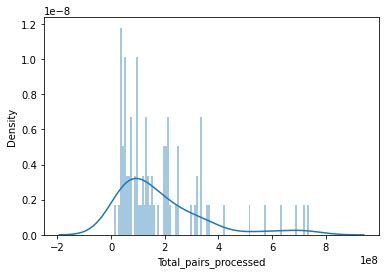

In [32]:
sns.distplot(all_stats.Total_pairs_processed, bins=100)

In [33]:
all_stats.sort_values("Valid_interaction_pairs")

,std_sample_name,Total_pairs_processed,Unmapped_pairs,Low_qual_pairs,Unique_paired_alignments,Multiple_pairs_alignments,Pairs_with_singleton,Low_qual_singleton,Unique_singleton_alignments,Multiple_singleton_alignments,Reported_pairs,Valid_interaction_pairs,Valid_interaction_pairs_FF,Valid_interaction_pairs_RR,Valid_interaction_pairs_RF,Valid_interaction_pairs_FR,Dangling_end_pairs,Religation_pairs,Self_Cycle_pairs,Single-end_pairs,Filtered_pairs,Dumped_pairs,valid_interaction,valid_interaction_rmdup,trans_interaction,cis_interaction,cis_shortRange,cis_longRange
77,mES_100k_cells.GSE101498.Mus_Musculus.H3K27ac.b2,57825242,56441425,11124,622,0,1372071,0,0,0,622,289,56,78,73,82,268,60,4,0,0,1,289,240,175,65,36,29
78,mES_500k_cells.GSE101498.Mus_Musculus.H3K27ac.b1,124627901,120685463,47675,3618,0,3891145,0,0,0,3618,326,75,73,41,137,2853,426,12,0,0,1,326,261,158,103,81,22
57,mES_500k_cells.GSE101498.Mus_Musculus.H3K27ac.b2,144063958,140170235,44989,3137,0,3845597,0,0,0,3137,336,45,75,62,154,2400,386,9,0,0,6,336,265,129,136,107,29
7,mES_50k_cells.GSE101498.Mus_Musculus.H3K27ac.b1,115461250,112936078,18081,1122,0,2505969,0,0,0,1122,513,127,112,118,156,481,110,16,0,0,2,513,408,307,101,45,56
43,mES_25m_cells.GSE101498.Mus_Musculus.H3K27ac.b1,321217020,313428160,63523,2552,0,7722785,0,0,0,2552,642,125,142,163,212,1579,315,14,0,0,2,642,572,355,217,155,62
68,mES_25m_cells.GSE101498.Mus_Musculus.H3K27ac.b2,333294302,323943717,67865,2284,0,9280436,0,0,0,2284,677,162,160,158,197,1331,238,35,0,0,3,677,600,419,181,105,76
15,Crypt.GSE148691.Mus_Musculus.H3K4me3.b1,96865408,93798844,28628,1427,0,3036509,0,0,0,1427,858,200,219,196,243,440,122,7,0,0,0,858,812,707,105,40,65
25,mES_50k_cells.GSE101498.Mus_Musculus.H3K27ac.b2,358002360,350948480,44506,2383,0,7006991,0,0,0,2383,1049,230,226,258,335,1008,302,20,0,0,4,1049,663,455,208,111,97
58,mES_100k_cells.GSE101498.Mus_Musculus.H3K27ac.b1,248686803,243226492,41820,2312,0,5416179,0,0,0,2312,1051,227,258,282,284,952,283,21,0,0,5,1051,853,641,212,110,102
79,Crypt-Hnf4DKO.GSE148691.Mus_Musculus.H3K4me3.b1,134608599,129677757,43918,2351,0,4884573,0,0,0,2351,1698,415,439,399,445,486,160,6,0,0,1,1698,1539,1376,163,54,109


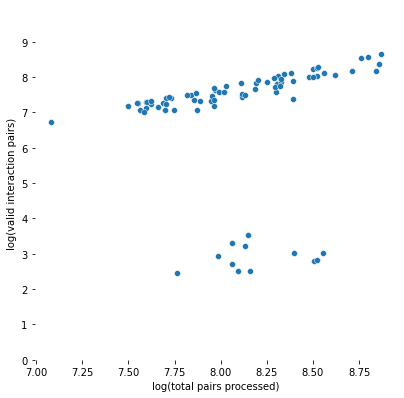

In [34]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x=np.log10(all_stats["Total_pairs_processed"]),
                y=np.log10(all_stats["Valid_interaction_pairs"]),
                ax=ax)
ax.set_xlabel('log(total pairs processed)')
ax.set_ylabel('log(valid interaction pairs)')
ax.set_ylim(0, 10)
ax.set_yticks(range(0, 10))

Text(0, 0.5, 'valid interaction pairs')

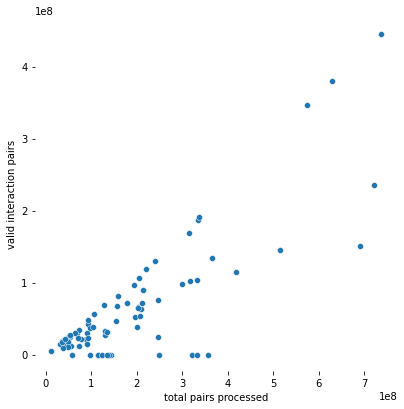

In [35]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x=all_stats["Total_pairs_processed"],
                y=all_stats["Valid_interaction_pairs"],
                ax=ax)
ax.set_xlabel('total pairs processed')
ax.set_ylabel('valid interaction pairs')
# ax.set_ylim(0, 10)
# ax.set_yticks(range(0, 10))

## Checking Kyra's Samples

In [36]:
ss = '/mnt/BioAdHoc/Groups/vd-ay/hichip-db-loop-calling/results/samplesheets/fastq/2022.04.09.16.57.fastq.samplesheet.with_header.tsv'

In [37]:
kf_data

NameError: name 'kf_data' is not defined

In [ ]:
kf_data = pd.read_table(ss)

In [ ]:
null_hic_samples = kf_data.iloc[[0,1,2,3,18,19]]

In [ ]:
null_hic_samples

In [ ]:
sparse_samples = kf_data.iloc[range(5,19)]

In [ ]:
sparse_samples

In [ ]:
all_stats.loc[all_stats.std_sample_name.isin(null_hic_samples.std_sample_name)]

In [ ]:
null_hic_samples.std_sample_name.tolist()

In [ ]:
all_stats

In [ ]:
hic_ss = '/mnt/BioAdHoc/Groups/vd-ay/hichip-db-loop-calling/results/samplesheets/hicpro/2022.04.09.16.57.hicpro.samplesheet.with_header.tsv'

In [ ]:
hic_ss_df = pd.read_table(hic_ss)

In [ ]:
hic_ss_df